# TORCphysics Example 3.: Gene Circuit Custom Models and Parameterization from TORCphysics

## Overview
This notebook revisits the system composed of two genes from Example 1, but we demonstrate how to define new enzymes and its binding sites with existing models and custom parameterisations.. We then analyse one system with analysis procedures shown in Example_1 and Example_2, running a single simulation and processing it through scripting.


## Gene Circuit Structure
We have a system composed by two genes in a tandem orientation in the form of:
X________-------left------>________------right------>________X

where X's indicate the surrounding barriers and -----> a gene pointing to the right.
We refer to the genes as 'left' and 'right'.

## Scenarios

### 3.1. Realistic Model (Accelerated): Multi-Stage Supercoiling-Dependent Transcription with Continuous Topoisomerase activity, and one enzyme randomly binds at the middle of genes, at a given rate and blocks supercoils.



In [1]:
# Load modules
# ------------------------------------------------------------------------------------------------------------------------
from TORCphysics import Circuit, Site, Environment
from TORCphysics import binding_model as bm
from TORCphysics import unbinding_model as ubm
from TORCphysics import visualization as vs
from TORCphysics import analysis as an
import numpy as np
import matplotlib.pyplot as plt

# EXPERIMENT 3.1

We can run a simulation of the two gene system with a custom enzyme and its binding site at the middle of the two genes.

In [2]:
# Simulation Conditions
# ------------------------------------------------------------------------------------------------------------------------
#Let's use sites_3.csv and environment_4.csv to produce multiple light and fast simulations.
# Using these inputs, will run the system with multistage supercoiling-dependent transcription initiation
# (closed -> open complex -> elongation) and  RNAP elongation (stalling included) with the continuum effect of topoisomerases acting
# on all topological domains.
# Simulation conditions
circuit_filename = 'circuit.csv'
sites_filename = 'sites_3.csv'  # This one contains transcription initiation modulated by supercoiling
enzymes_filename = None  # This input is optional, no enzymes_file means that nothing is bound
environment_filename = 'environment_4.csv'  # This one contains uniform RNAPs and topoisomerases acting continously
output_prefix = 'output2'
frames = 3600
series = True
continuation = False
dt = 1

n_sims = 20 # We will run n_sims simulations for this example.

gene_names = ['left', 'right']

colors = {'left': 'yellow', 'right': 'blue', 'circuit': 'black'}  # circuit refers to global quantities, e.g. global supercoiling



In [3]:
# Initialize circuit with the initial conditions
my_circuit = Circuit(circuit_filename, sites_filename, enzymes_filename, environment_filename,
                     output_prefix, frames, series, continuation, dt)

In [4]:
# We now need to define a binding site for our new enzyme which binds at a constant rate
custom_site = Site(site_type='custom_site', name='custom_site', start=2500, end=0, k_on=0.0025, binding_model=bm.PoissonBinding())
my_circuit.site_list.append(custom_site)


In [5]:
# Define new environment custom enzyme which can bind its corresponding binding site.
# If no effect model is given, the enzyme will not move and will not introduce additional twist/supercoiling, but it will block the
# propagation
custom_enzyme = Environment(e_type='custom_enzyme', name='custom_enzyme', site_list=my_circuit.site_list, concentration=1.0, size=20,
                                effective_size=10, site_type='custom_site',
                            unbinding_model=ubm.PoissonUnBinding(**{'k_off':0.05}))
my_circuit.environmental_list.append(custom_enzyme)

In [6]:
# Update lists and twist/supercoiling in the circuit components
my_circuit.sort_lists()
my_circuit.update_global_twist()
my_circuit.update_global_superhelical()
enzymes_df, sites_df, environment_df = my_circuit.run_return_dfs() # Function run_return_dfs() returns the dataframes with the results of the simulation (it does not write CSV files).


left gene production rate: 0.01 transcript/seconds
right gene production rate: 0.006944444444444444 transcript/seconds


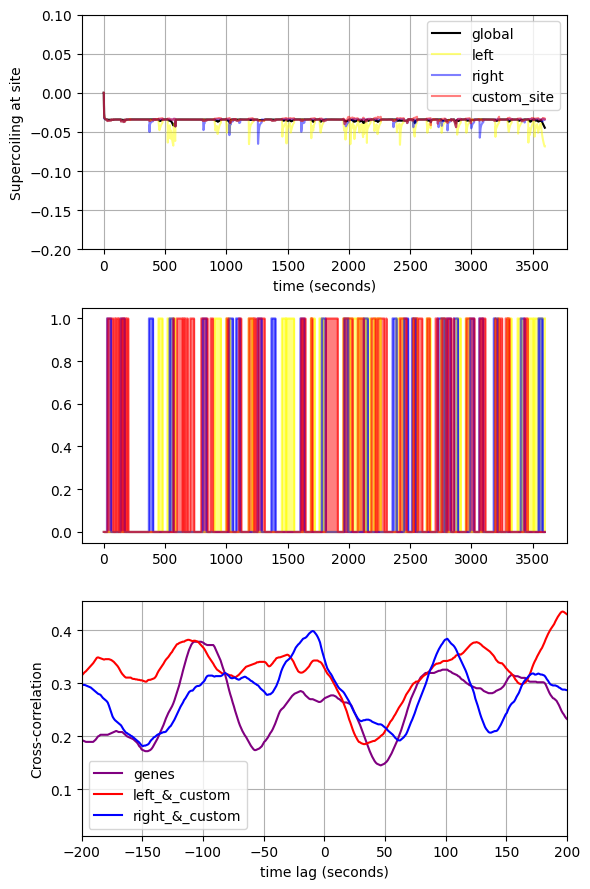

In [7]:
# This time, let's put all the plots in one figure
gene_names = ['left', 'right']
names = ['left', 'right', 'custom_site']
colors = {'left': 'yellow', 'right': 'blue', 'custom_site': 'red'}
fig, axs = plt.subplots(3, figsize=(6,9), tight_layout=True)

# Plot supercoiling
vs.plot_supercoiling_profiles(my_circuit, sites_df, colors=colors, axs=axs[0])#, only_global=True)

# Plot elongation signal
signals = an.build_elongation_signal_stages(enzymes_df, gene_names)
custom_enzyme_signal = an.build_signal_by_name(enzymes_df, 'custom_enzyme')
signals.append(custom_enzyme_signal)
time = np.arange(0, my_circuit.dt * len(signals[0]), my_circuit.dt)
y_0s = time * 0.0
for i, signal in enumerate(signals):
    name = names[i]
    axs[1].plot(time, signal, color=colors[name], label=name, alpha=0.5)
    axs[1].fill_between(time, signal, y_0s, color=colors[name], alpha=0.5)

# Plot cross correlations
crossmatrix, lag =  an.cross_correlation_hmatrix(signals, dt)
#my_label = f' lag={lag[np.argmax(crossmatrix[0, 1, :])]:.2f}s'
axs[2].plot(lag, crossmatrix[0, 1, :], color='purple', label='genes')
axs[2].plot(lag, crossmatrix[0, 2, :], color='red', label='left_&_custom')
axs[2].plot(lag, crossmatrix[1, 2, :], color='blue', label='right_&_custom')
axs[2].set_ylabel('Cross-correlation')
axs[2].set_xlabel('time lag (seconds)')
axs[2].set_xlim(-200, 200)
axs[2].legend(loc='best')
axs[2].grid(True)

#vs.plot_cross_correlation_with_site(my_circuit, sites_df, ref_name='left', axs=axs[2])

# And let's calculate the production rate:
for gene_name in gene_names:
    mask = environment_df['name'] == gene_name
    transcripts = environment_df[mask]['concentration'].iloc[-1]
    print(gene_name + ' gene production rate: ' + str(transcripts/(frames*dt)) +' transcript/seconds')

## Takeaway Notes:
- You can use existing models within TORCphysics to define new behaviours in terms of binding, effect and unbinding.